# Experiments: Utility-based Adaptive Teaching Strategies using Bayesian Theory of Mind
## 2D navigation task

In [1]:
from __future__ import annotations
import warnings

import sys
sys.path.append('../')

from minigrid.core.actions import Actions
from minigrid.core.constants import IDX_TO_COLOR, DIR_TO_VEC

import numpy as np
import pickle
import csv
from matplotlib import patches
import matplotlib.pyplot as plt
from tqdm import trange, tqdm
import progressbar
import pandas as pd

from matplotlib.backends.backend_agg import FigureCanvasAgg
import matplotlib.gridspec as gridspec
from IPython.display import clear_output
from PIL import Image

from environment import MultiGoalsEnv, MultiRoomsGoalsEnv 
from learner import BayesianLearner
from bayesian_ToM.bayesian_teacher import AlignedBayesianTeacher, BayesianTeacher
from tools.utils import *
from tools.utils_viz import *

warnings.filterwarnings("ignore", category=RuntimeWarning)

pygame 2.4.0 (SDL 2.26.4, Python 3.11.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# Parameters

GRID_SIZE = 11
GRID_SIZE_DEMO = 33
num_colors = 4
rf_values_basic = [3, 5]
RF_VALUES = rf_values_basic + [GRID_SIZE]
RF_VALUES_DEMO = rf_values_basic + [GRID_SIZE_DEMO]

## Environment

Our framework is composed of two environments constructed with the [Minigrid](https://minigrid.farama.org/) library: a simple environment in which the teacher observes the learner behaving on its own, and a more complex environment in which the teacher can provide a demonstration to help the learner.


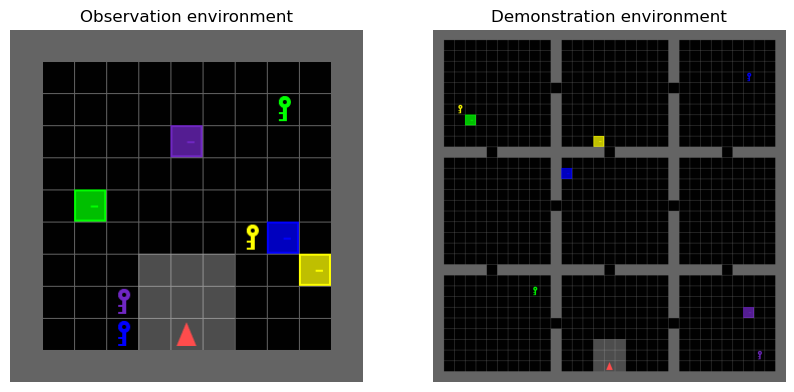

In [3]:
fig_learner = plt.figure(figsize=(10, 5))

env = MultiGoalsEnv(render_mode = "rgb_array",
                    agent_goal=0, agent_view_size=3, 
                    agent_start_pos=(GRID_SIZE//2, GRID_SIZE-2), agent_start_dir=3,
                    size=GRID_SIZE)
_ = env.reset()

fig_learner.add_subplot(1,2,1)
plt.imshow(env.render())
plt.axis('off')
plt.title('Observation environment')

env_demo = MultiRoomsGoalsEnv(render_mode = "rgb_array",
                    agent_goal=0, agent_view_size=3, 
                    agent_start_pos=(GRID_SIZE_DEMO//2, GRID_SIZE_DEMO-2), agent_start_dir=3,
                    size=GRID_SIZE_DEMO)
_ = env_demo.reset()

fig_learner.add_subplot(1,2,2)
plt.imshow(env_demo.render())
plt.axis('off')
plt.title('Demonstration environment');

## Learner (Bayesian decision tree)

The learner's policy is constructed as decision tree based on shortest path algorithms A*. The learner has a belief about the state of the environment and updates it at every step of its trajectory.

We display the evolution of its belief as the Shanon entropy of the belief on each cell of the environment.

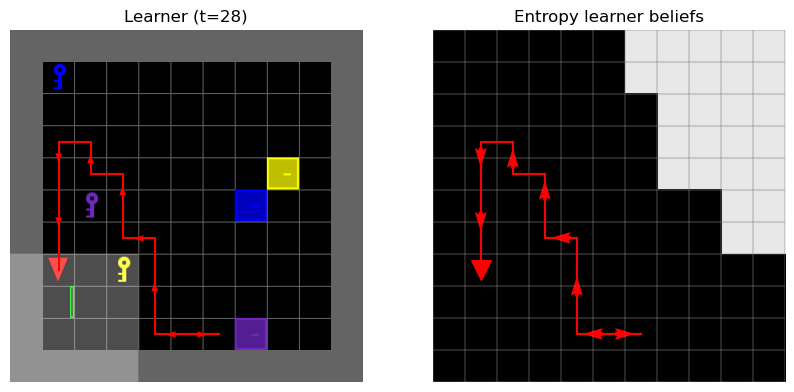

In [4]:
receptive_field = 5
goal_color = 0

learner = BayesianLearner(goal_color=goal_color, receptive_field=receptive_field, grid_size=GRID_SIZE, env_type='MultiGoalsEnv')
images_learner = display_learner_play(GRID_SIZE, learner, width=0.03, width_belief=0.02, figsize=(10, 5), size=200)

### Statistics on different learners

We compute statistics on the peformances of the learners alone on the two environments.

In [5]:
# Paremeters

GRID_SIZE = 11
N = 100

env_type = 'MultiRoomsGoalsEnv'

if env_type =='MultiGoalsEnv':
    grid_size = GRID_SIZE
    rf_values = rf_values_basic + [GRID_SIZE]
    
elif env_type == 'MultiRoomsGoalsEnv':
    grid_size = GRID_SIZE_DEMO
    rf_values = rf_values_basic + [GRID_SIZE_DEMO]

print(f'Environment {env_type} \n \
      grid_size {grid_size} \n \
      rf_values {rf_values}')

Environment MultiRoomsGoalsEnv 
       grid_size 33 
       rf_values [3, 5, 33]


In [10]:
mean_reward_all = np.zeros((num_colors, len(rf_values)))
std_reward_all = np.zeros((num_colors, len(rf_values)))

mean_count_all = np.zeros((num_colors, len(rf_values)))
std_count_all = np.zeros((num_colors, len(rf_values)))

for goal_color in range(num_colors):
    for ii,receptive_field in enumerate(rf_values):
        rewards_all = []
        counts_all = []
        for _ in trange(N):
            learner = BayesianLearner(goal_color=goal_color, receptive_field=receptive_field, grid_size=grid_size, env_type=env_type)
            learner.play()
            
            # Stats
            rewards_all.append(learner.reward)
            counts_all.append(learner.env.step_count)

        mean_reward_all[goal_color, ii] = np.mean(rewards_all)
        std_reward_all[goal_color, ii] = 1.96 * np.std(rewards_all) / np.sqrt(N)

        mean_count_all[goal_color, ii] = np.mean(counts_all)
        std_count_all[goal_color, ii] = 1.96 * np.std(counts_all) / np.sqrt(N)

100%|██████████| 100/100 [00:59<00:00,  1.69it/s]


##### On the observation environment

In [11]:
mean_std_reward = np.zeros((num_colors, len(rf_values))).astype(str)

for goal in range(num_colors):
    for ii,rf in enumerate(rf_values):
        mean_std_reward[goal, ii] = str(np.round(mean_reward_all[goal, ii], 4)) + " +/- " + str(np.round(std_reward_all[goal, ii], 4))

df_reward = pd.DataFrame(mean_std_reward, columns=np.array(rf_values).astype('str'), index=['Green', 'Blue', 'Purple', 'Yellow'])

mean_std_count = np.zeros((num_colors, len(rf_values))).astype(str)

for goal in range(num_colors):
    for ii,rf in enumerate(rf_values):
        mean_std_count[goal, ii] = str(np.round(mean_count_all[goal, ii], 4)) + " +/- " + str(np.round(std_count_all[goal, ii], 4))

df_count = pd.DataFrame(mean_std_count, columns=np.array(rf_values).astype('str'), index=['Green', 'Blue', 'Purple', 'Yellow'])

print("Reward per type of learner")
display(df_reward)
print("# of steps to fininsh the task per type of learner")
display(df_count)

Reward per type of learner


,3,5,11
Green,0.6521 +/- 0.0525,0.7897 +/- 0.0277,0.8613 +/- 0.0072
Blue,0.5973 +/- 0.0603,0.814 +/- 0.023,0.8668 +/- 0.0074
Purple,0.5798 +/- 0.0548,0.7952 +/- 0.0313,0.8666 +/- 0.0079
Yellow,0.5963 +/- 0.0585,0.7949 +/- 0.0214,0.8668 +/- 0.0083


# of steps to fininsh the task per type of learner


,3,5,11
Green,45.3 +/- 6.3596,28.0 +/- 3.4357,18.65 +/- 0.9735
Blue,51.99 +/- 7.3079,24.87 +/- 2.9093,17.91 +/- 1.001
Purple,54.75 +/- 6.6763,27.26 +/- 3.955,17.93 +/- 1.0574
Yellow,52.26 +/- 7.09,27.57 +/- 2.8776,17.91 +/- 1.1119


##### On the demonstration environment

In [11]:
mean_std_reward = np.zeros((num_colors, len(rf_values))).astype(str)

for goal in range(num_colors):
    for ii,rf in enumerate(rf_values):
        mean_std_reward[goal, ii] = str(np.round(mean_reward_all[goal, ii], 4)) + " +/- " + str(np.round(std_reward_all[goal, ii], 4))

df_reward = pd.DataFrame(mean_std_reward, columns=np.array(rf_values).astype('str'), index=['Green', 'Blue', 'Purple', 'Yellow'])

mean_std_count = np.zeros((num_colors, len(rf_values))).astype(str)

for goal in range(num_colors):
    for ii,rf in enumerate(rf_values):
        mean_std_count[goal, ii] = str(np.round(mean_count_all[goal, ii], 4)) + " +/- " + str(np.round(std_count_all[goal, ii], 4))

df_count = pd.DataFrame(mean_std_count, columns=np.array(rf_values).astype('str'), index=['Green', 'Blue', 'Purple', 'Yellow'])

print("Reward per type of learner")
display(df_reward)
print("# of steps to fininsh the task per type of learner")
display(df_count)

Reward per type of learner


,3,5,33
Green,0.0377 +/- 0.0294,0.223 +/- 0.0625,0.9053 +/- 0.0049
Blue,0.0649 +/- 0.0371,0.1831 +/- 0.0569,0.9021 +/- 0.0052
Purple,0.0333 +/- 0.0285,0.2388 +/- 0.0645,0.9016 +/- 0.0054
Yellow,0.059 +/- 0.036,0.2154 +/- 0.0598,0.9022 +/- 0.0052


# of steps to fininsh the task per type of learner


,3,5,33
Green,526.05 +/- 15.1023,430.94 +/- 32.5088,57.24 +/- 2.9855
Blue,513.26 +/- 19.0652,453.25 +/- 29.4663,59.15 +/- 3.1239
Purple,527.49 +/- 14.752,423.22 +/- 33.8266,59.45 +/- 3.2346
Yellow,515.01 +/- 18.4093,436.77 +/- 31.0799,59.09 +/- 3.1228


## Bayesian ToM-teachers

### Aligned ToM-teacher: knowing rational learner AND its strategies

This ToM-teacher has access to the real behavioural policy of the learner which can be decomposed into two policy modes:

 - **Greedy policy:** Follow the shortest path computed by A* algorithm to the object (goal or subgoal)
 - **Exploration policy:** Active exploration, take the action that minimises the global uncertainty on the env i.e. that maximizes the discovery

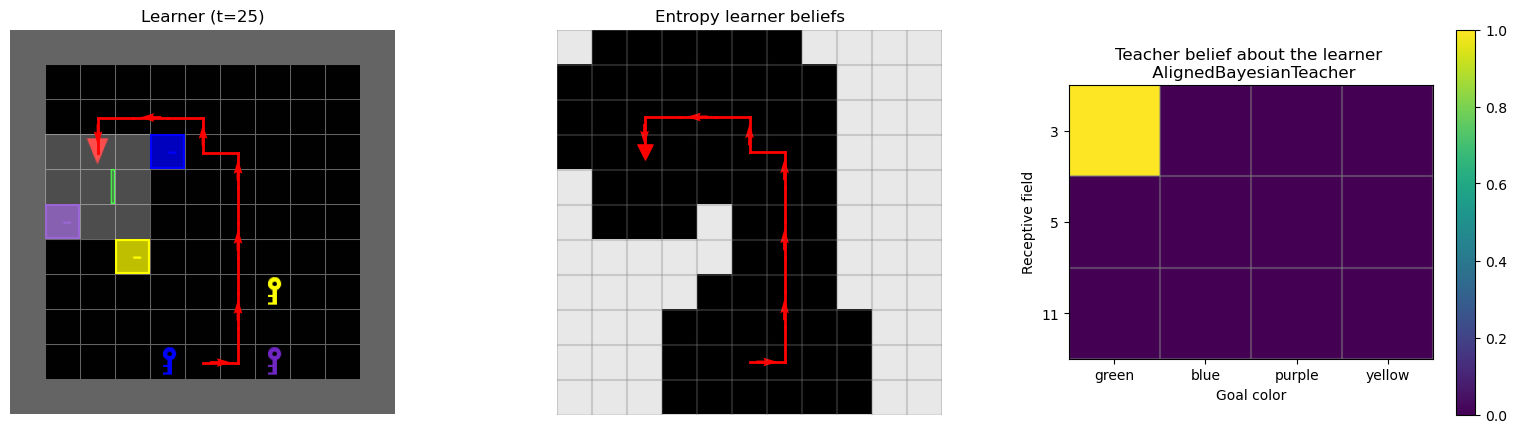

In [6]:
GRID_SIZE = 11

receptive_field = 3
goal_color = 0

learner = BayesianLearner(goal_color=goal_color, receptive_field=receptive_field, grid_size=GRID_SIZE) #, save_render=True)
teacher = AlignedBayesianTeacher(env=learner.env, rf_values=rf_values_basic)

images = display_learner_play_teacher_infer(GRID_SIZE, learner, teacher, linewidth=2)

In [61]:
# Save gif
gif_file = f"./outputs/rendering/map_3.gif"
images[0].save(gif_file, save_all=True, append_images=images[1:], duration=300, loop=0)

In [ ]:
# Debugging
save_LOG("./outputs_rendering/bug/LOG_teacher.csv", teacher)
save_LOG("./outputs_rendering/bug/LOG_learner.csv", learner)

### Rational ToM-Teacher: only knowing that the learner is rational

This ToM-teacher has an approximation of the behavioural policy of the learners. This approximation, like the real policy, can be decomposed into two policy modes:

 - **Greedy policy:** Boltzman policy with temperature parameter $\lambda$ favoring acting towards the object (goal or subgoal)
 - **Exploration policy:** Uniform

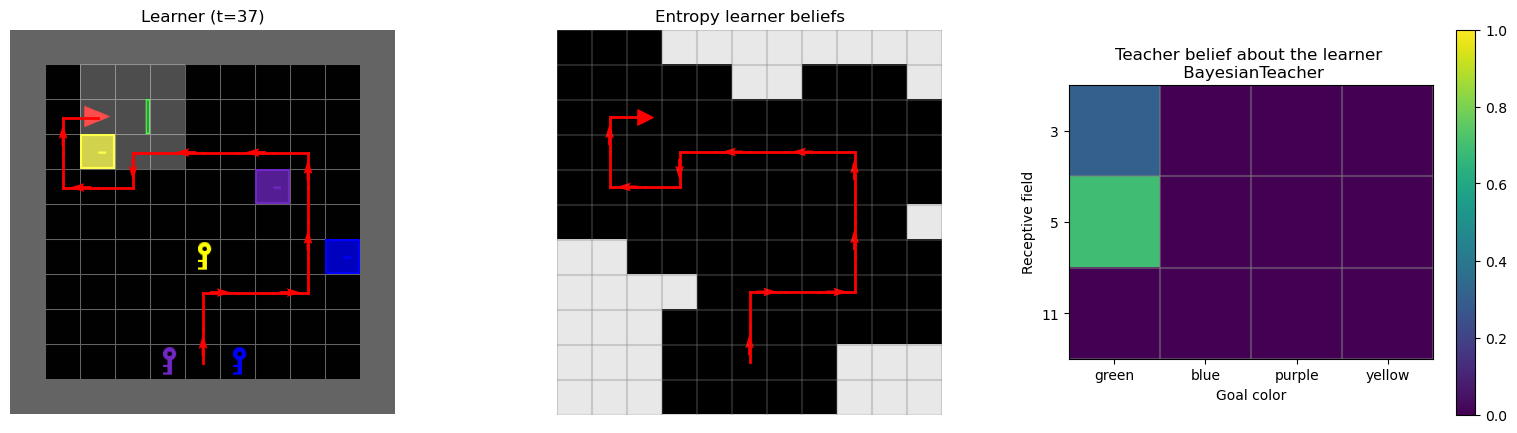

In [7]:
GRID_SIZE = 11

receptive_field = 3
goal_color = 0
lambd = 0.1

learner = BayesianLearner(goal_color=goal_color, receptive_field=receptive_field, grid_size=GRID_SIZE) #, save_render=True)
teacher = BayesianTeacher(env=learner.env, lambd=lambd, rf_values=rf_values_basic)

images_learner = display_learner_play_teacher_infer(GRID_SIZE, learner, teacher, linewidth=2)

In [ ]:
# Debugging
save_LOG("./outputs_rendering/bug/LOG_teacher.csv", teacher)
save_LOG("./outputs_rendering/bug/LOG_learner.csv", learner)

### Comparing the ToM models of the aligned and rational ToM-teachers

We represent the beliefs of the ToM-teachers regarding the learner's trajectory using Shannon entropy to quantify uncertainty both about the goal and the receptive field size. Additionally, we provide the predicted goal colour at each step as the mean value computed from the four possible goal colours, weighted by the teachers' beliefs. We employ the same process to represent predictions about the receptive field size. This predictions are displayed on the bottom of the figure.

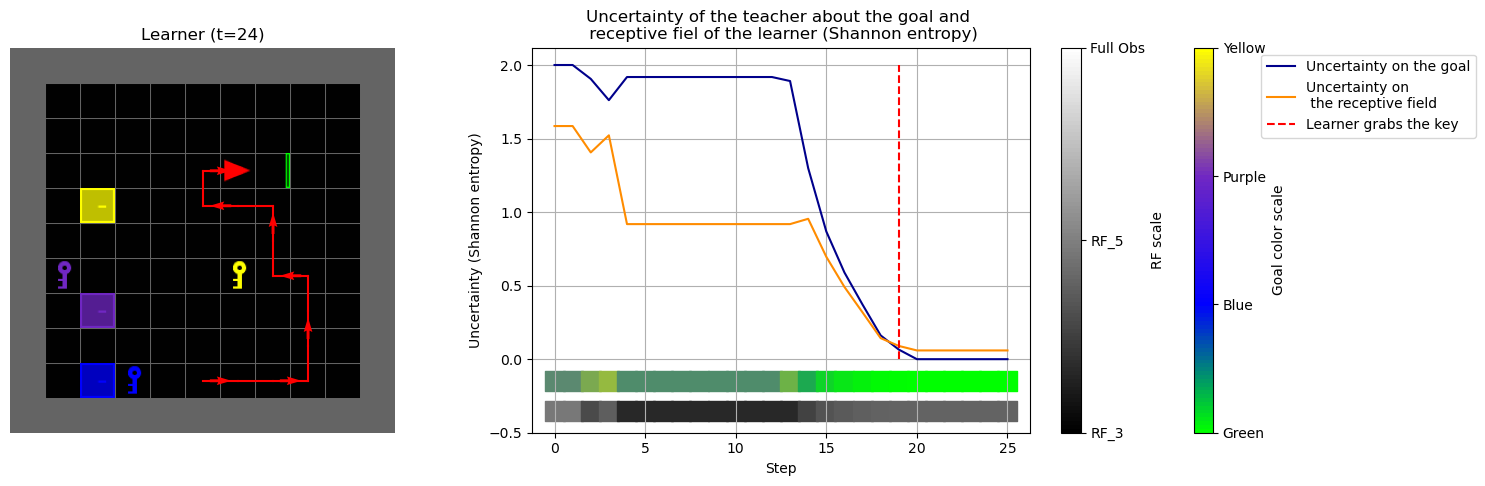

In [3]:
GRID_SIZE = 11

receptive_field = 3
goal_color = 0

lambd = 0.01

learner = BayesianLearner(goal_color=goal_color, receptive_field=receptive_field, grid_size=GRID_SIZE)
teacher = BayesianTeacher(env=learner.env, lambd=lambd, rf_values=rf_values_basic)


images_learner = display_learner_play_teacher_infer_blind_with_uncertainty_color(learner, teacher)

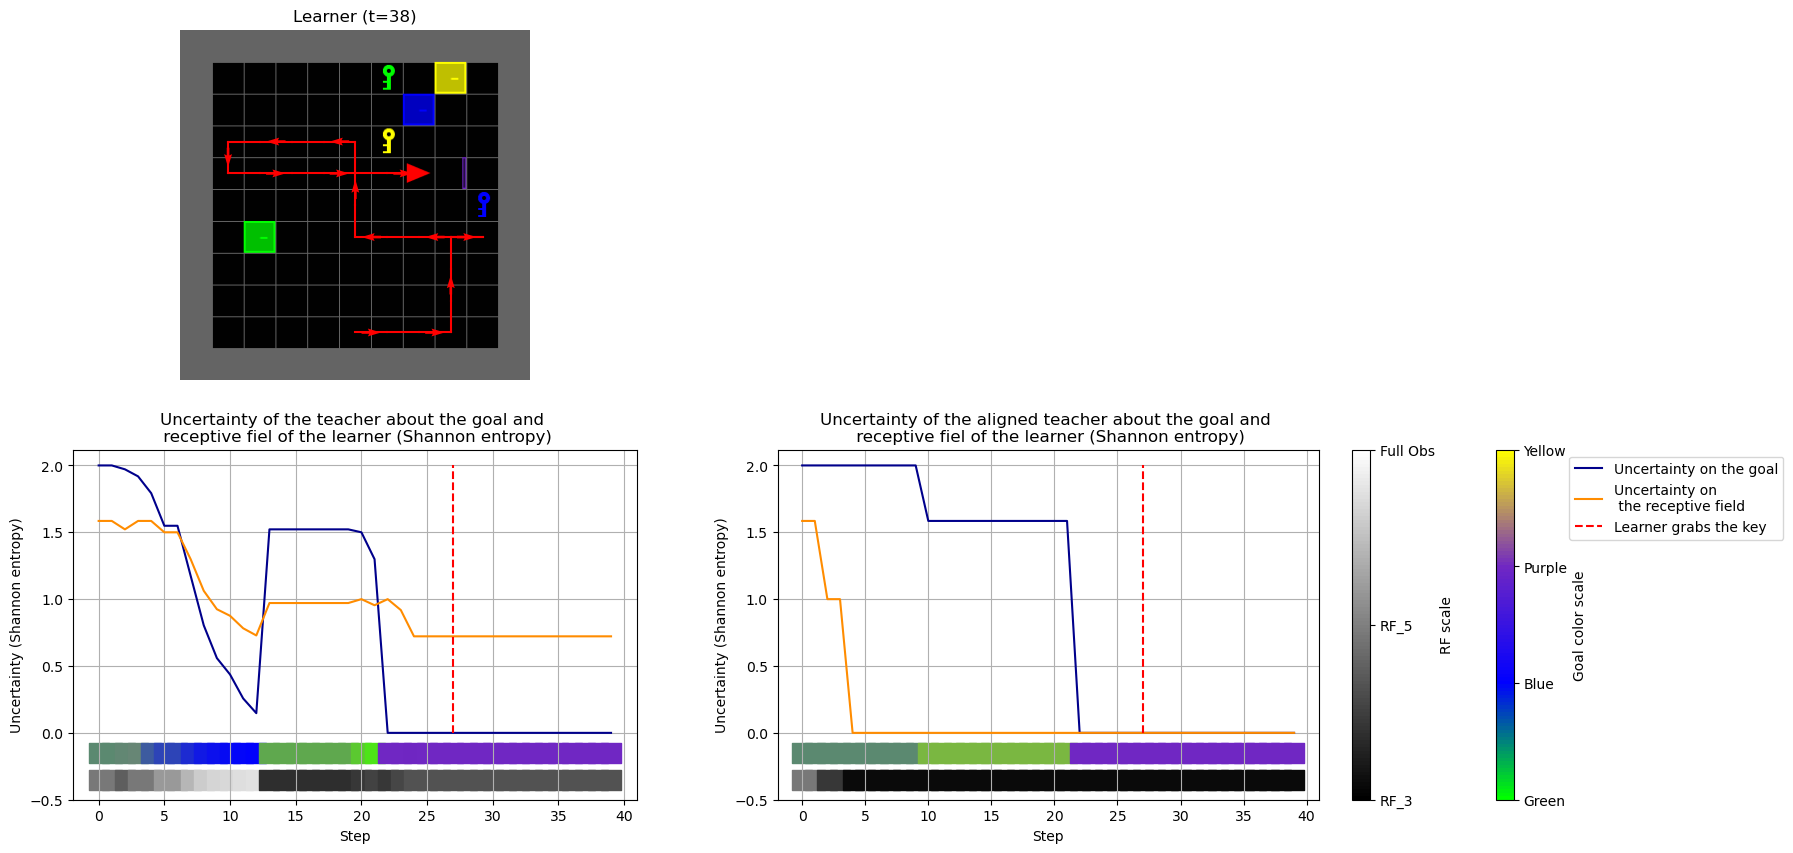

In [50]:
GRID_SIZE = 11

receptive_field = 3
goal_color = 2
lambd = 0.01

learner = BayesianLearner(goal_color=goal_color, receptive_field=receptive_field, grid_size=GRID_SIZE)
# learner.reset()

images_learner = display_learner_play_both_teachers_infer_blind_with_uncertainty_color(learner, rf_values_basic=rf_values_basic)

In [35]:
# Save gif
make_dirs("./outputs/rendering/ToM_only_goal")
gif_file = f"./outputs/rendering/ToM_only_goal/both_teacher_12.gif"
images_learner[0].save(gif_file, save_all=True, append_images=images_learner[1:], duration=400, loop=0)

### Influence of the size of the observation environment on the ToM models
#### Accuracy of the MAP estimators of the learner's receptive field size

In these experiments, we manipulate the size of the observation environment and evaluate the accuracy of the MAP estimators of the ToM-teachers' beliefs after observing a complete trajectory of the learner.

We observe that as we increase the size of the observation environment, the accuracy of the MAP estimator of the learner's receptive field size of the aligned ToM-teacher converges toward 1. The MAP estimators of the rational ToM-teachers also exhibit improved accuracy as the size of the observation environment increases.

This can be attributed to the fact that the learner must take more actions to achieve its goal. Consequently, the teacher has access to longer observations, resulting better modelling of the learner's internal state and thus higher accuracy in larger environments.

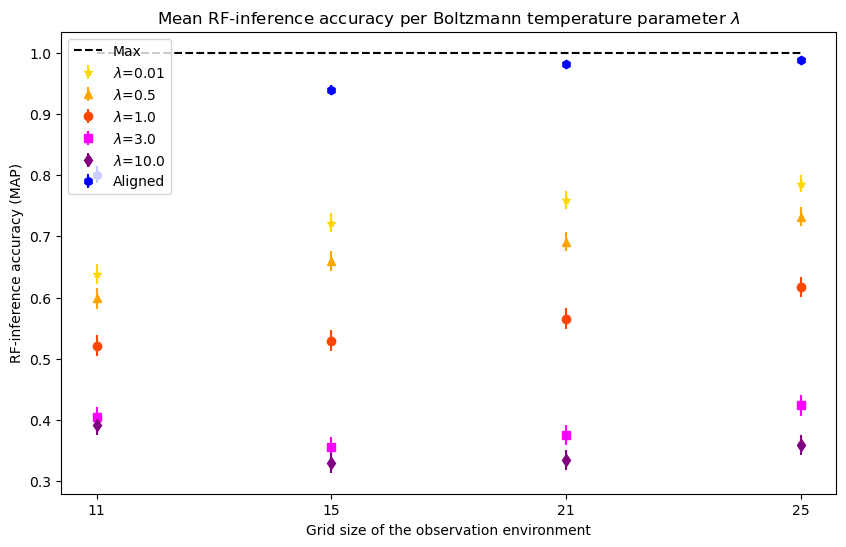

In [3]:
grid_size_values = [11, 15, 21, 25]
lambd_values = [0.01, 0.5, 1., 3., 10.]

display_all_ToM('../outputs/exp_varying_obs_env/', lambd_values, grid_size_values)

## Demonstration

We define the teaching cost function as linear function normalised by the size of the longest demonstration of the provided dataset (in practice it is the demonstration showing all the objects of the environment).

In [3]:
alpha = 0.6
def cost_fun(x: int, l: int) -> float:
    return alpha * (x / l)

## Complete interaction framework
 * **(A)** The teacher observes the learner in a simple environment and updates its belief about its internal state (i.e. goal and receptive field size)

 * **(B)** The teacher selects the demonstration maximising the estimated utility for the observed learner
 
 * **(C)** The learner observed the selected demonstration and plays in the demonstration observation resulting in a reward
    * The teacher is evaluated on the utility, that is the reward of the learner minus the cost of the selected demonstration

In [4]:
GRID_SIZE = 11
GRID_SIZE_DEMO = 33

print(f'MultiGoalsEnv observation nvironment: \n \
      GRID_SIZE {GRID_SIZE}\n \
      (max_steps={GRID_SIZE**2}) \n')

print(f'MultiRoomsGoalsEnv demonstration environment: \n \
      GRID_SIZE {GRID_SIZE_DEMO}\n \
      (max_steps={GRID_SIZE_DEMO**2/2}) \n')

idx = 0
receptive_field = RF_VALUES[idx]
goal_color = 0
print(f'Leaner: \n \
      rf={receptive_field} \n \
      goal_color={IDX_TO_COLOR[goal_color+1]} \n')

lambd = 0.01
print(f'Teacher: \n \
      Boltzmann temperatire lambda={lambd}')

rf_values_basic = [3, 5]
rf_values = np.array(rf_values_basic + [GRID_SIZE])
rf_values_demo = np.array(rf_values_basic + [GRID_SIZE_DEMO])

MultiGoalsEnv observation nvironment: 
       GRID_SIZE 11
       (max_steps=121) 

MultiRoomsGoalsEnv demonstration environment: 
       GRID_SIZE 33
       (max_steps=544.5) 

Leaner: 
       rf=3 
       goal_color=green 

Teacher: 
       Boltzmann temperatire lambda=0.01


### **(A)** The teacher observes the learner and fit its model

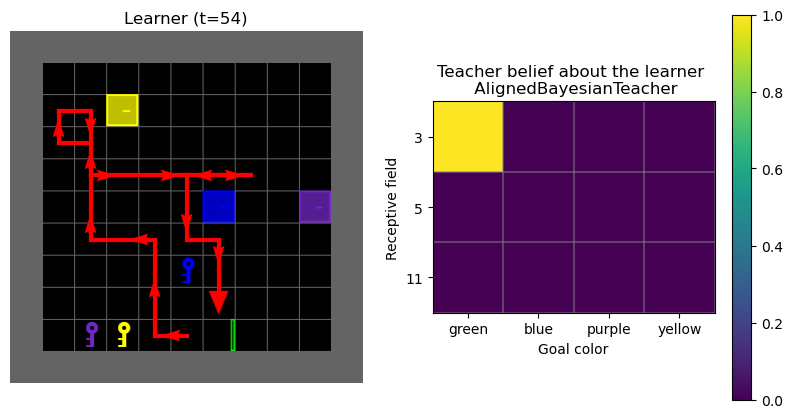

In [5]:
learner = BayesianLearner(goal_color=goal_color, receptive_field=receptive_field, grid_size=GRID_SIZE) #, save_render=True)
# teacher = BayesianTeacher(env=learner.env, lambd=lambd)
teacher = AlignedBayesianTeacher(env=learner.env, rf_values=rf_values_basic)

images_learner = display_learner_play_teacher_infer_blind(learner, teacher, width=0.055, linewidth=3)

In [ ]:
## Save as a gif
gif_file = f"./outputs_rendering/demonstrations/example_1/observation_rf_{receptive_field}.gif"
images_learner[0].save(gif_file, save_all=True, append_images=images_learner[1:], duration=200, loop=0)

### **(B)** The teacher selects the demonstration maximising the expected utility for the observed learner

In [6]:
learner = BayesianLearner(goal_color=goal_color, receptive_field=receptive_field, grid_size=GRID_SIZE_DEMO, env_type='MultiRoomsGoalsEnv')
teacher.init_env(learner.env)

selected_demo, demo_idx, predicted_best_utility, demos = teacher.select_demo(200, cost_fun)

#### The learner observes the selected demonstration and aquirses knowledge about the complex environment

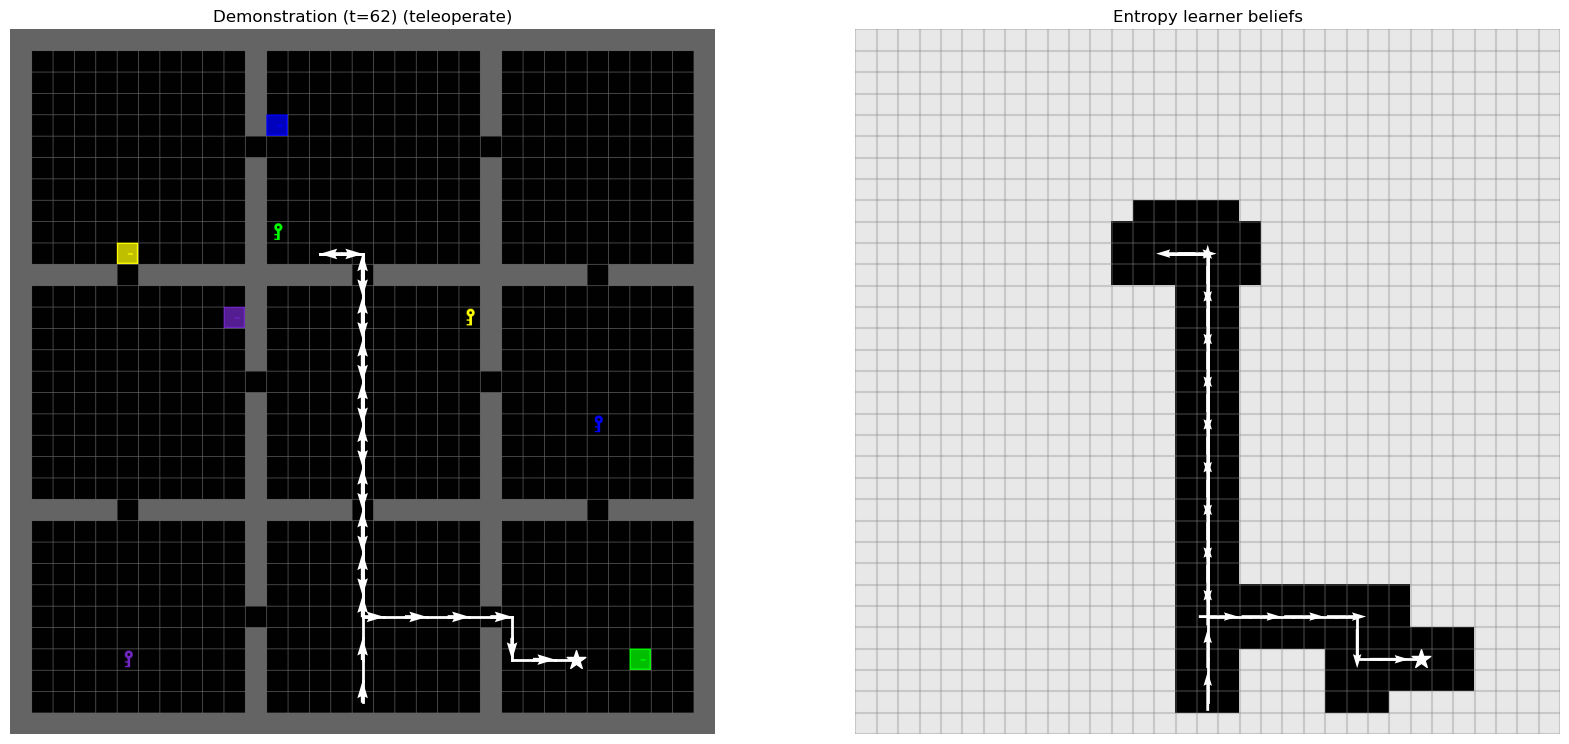

In [7]:
# Display demonstration and learner beliefs update

learner.env.highlight = False
learner.observe(selected_demo)
images_learner = display_learner_obs_demo(GRID_SIZE_DEMO, learner, width=0.005, start_size=200, linewidth=2)

In [49]:
## Save as a gif
gif_file = f"./outputs/demonstrations/demo_1.gif"
images_learner[0].save(gif_file, save_all=True, append_images=images_learner[1:], duration=200, loop=0)

### **(C)** The learner behaves in the demonstration environment

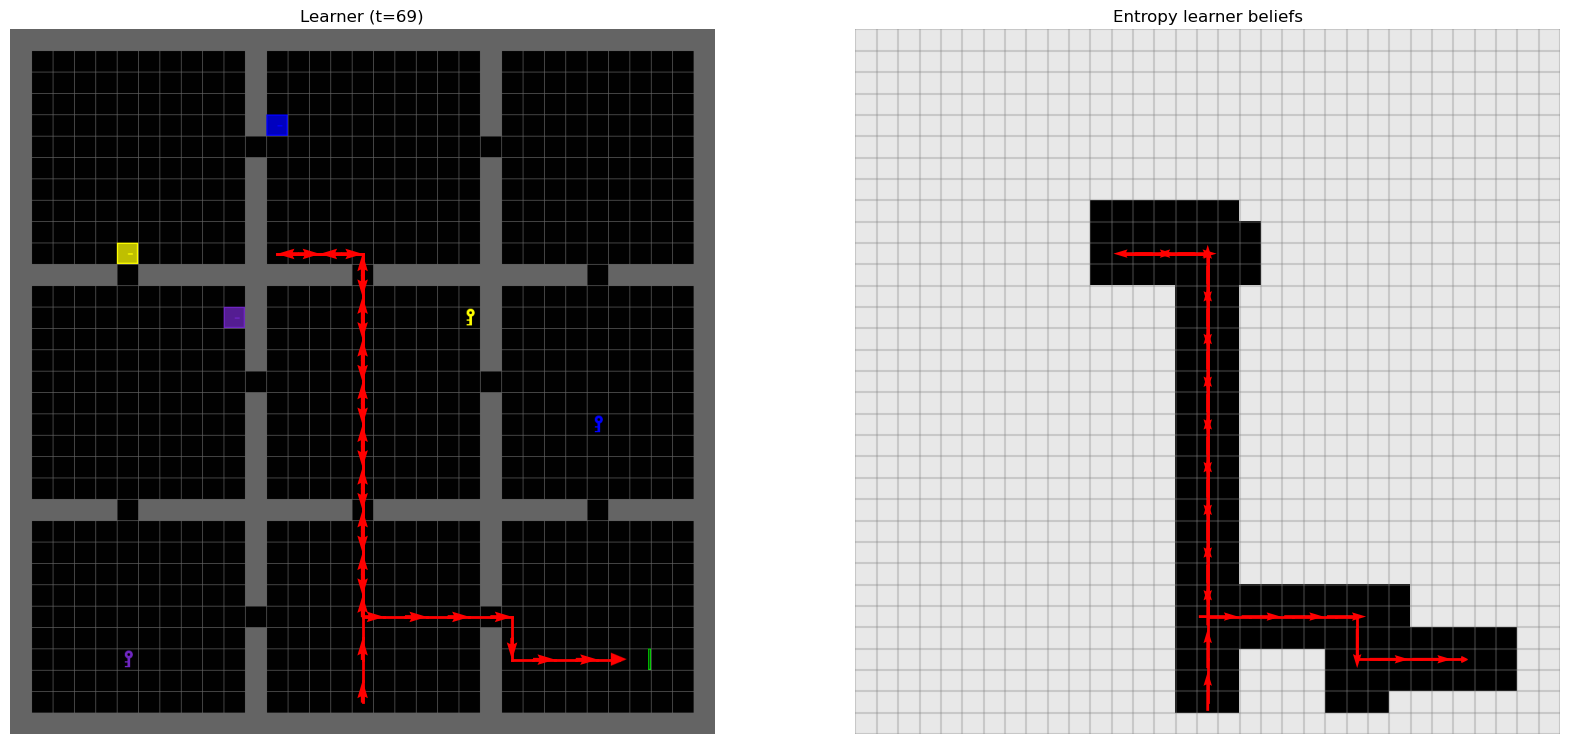

Reward: 0.8842


In [8]:
# Display learner playing after observing the demo

images_learner = display_learner_play(GRID_SIZE_DEMO, learner, size=15, width=0.005, linewidth=2)
print(f'Reward: {learner.reward:.4f}')

In [22]:
## Save as a gif
gif_file = f"./outputs/demonstrations/eval_1.gif"
images_learner[0].save(gif_file, save_all=True, append_images=images_learner[1:], duration=200, loop=0)